# **SetUp**

In [1]:
!nvidia-smi

Sun Mar  1 05:22:57 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    On  |   00000000:05:00.0 Off |                    0 |
| N/A   30C    P8             33W /  350W |       0MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **ZO**

实验层级配置

L0 Baseline（默认）
- `BATCHDIFF_CKPT = -1`
- 按 `SAVE_STEPS` 固定频率保存**完整 checkpoint**

L1 Batch Differential Checkpoint
- `BATCHDIFF_CKPT = 0`：Log-based（从 base 开始累积所有 updates）
- `BATCHDIFF_CKPT = 1`：Pure Differential（只保存当前 step 的 update）
- `BATCHDIFF_CKPT = N (N >= 2)`：Batch Differential（每 `N` 步生成一次新的 full checkpoint）
对于 batch_size >= 2 (Batch Differential 模式):

save_full_model=False (默认):

每 N 步：更新 base_checkpoint_state（内存），清空 update_history
只保存 batch_diff_meta.pt 和 zo_replay_history.json（空的）
不保存 model.safetensors 或 pytorch_model.bin
恢复时从初始缓存模型开始，replay 所有差分 checkpoint
save_full_model=True:

每 N 步：更新 base_checkpoint_state（内存），清空 update_history
保存 batch_diff_meta.pt、zo_replay_history.json 和完整的模型文件
恢复时可以从最近的完整 checkpoint 开始，减少 replay 的步数

L2 CPU Shadow
- `ENABLE_SHADOW = 1`
- 依赖：`BATCHDIFF_CKPT >= 0`
- CPU 端实时维护 **shadow model**

L3 即时恢复
- `INSTANT_RECOVER = 1`
- 依赖：`L2 + GPU_FAIL_STEP`
- 故障后立即恢复

GPU 故障注入（旁路）
- `GPU_FAIL_STEP = N`
- 在第 `N` 步模拟 GPU 故障
- 可单独使用

In [ ]:
# 简单staging
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_staging_8 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=1 DO_EVAL=0 \
    BATCHDIFF_CKPT=-1 \
    bash /home/users/u0001609/NonStopZO2/example/mezo_runner/mezo.sh

In [15]:
# diff
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_staging_10 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=1 DO_EVAL=0 \
    BATCHDIFF_CKPT=0 \
    bash /home/users/u0001609/NonStopZO2/example/mezo_runner/mezo.sh

# **Resume**

Resume / Replay
- If BATCHDIFF_CKPT=-1 用 RESUME_CKPT 走 HuggingFace 标准恢复
- `BATCHDIFF_RESUME`
- 从指定的 full checkpoint 恢复，自动扫描并重放后续的 differential checkpoints
- BATCHDIFF_REPLAY_DEVICE=cuda参数（cpu 或 cuda）

In [ ]:
# 简单staging
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_resume_5 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=100 DO_EVAL=0 \
    BATCHDIFF_CKPT=-1 \
    RESUME_CKPT="/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/141748-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100" \
    bash /home/ubuntu/NonStopZO2/example/mezo_runner/mezo.sh

Using GPU: 0
========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 100
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: -1 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: 
Extra args:  --resume_from_checkpoint /home/ubuntu/ZO_ckpt/Test_staging_7-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-600 --no_eval 
2026-02-22 18:50:08,681 - INFO - PyTorch version 2.10.0 available.
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
batchdiff_ckpt=-1,
batchdiff_

In [ ]:
# 简单staging
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_resume_2 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=1 DO_EVAL=0 \
    BATCHDIFF_CKPT=0 BATCHDIFF_REPLAY_DEVICE=cuda \
    BATCHDIFF_RESUME="/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/141938-SST2-Qwen3-8B-mezo-ft-1e-7-1e-4-0/checkpoint-100" \
    bash /home/ubuntu/NonStopZO2/example/mezo_runner/mezo.sh

Using GPU: 0
========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 1
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: 0 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: /home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100
BATCHDIFF_REPLAY_DEVICE: cuda
Extra args:  --batchdiff_ckpt 0 --batchdiff_resume /home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100 --batchdiff_replay_device cuda --no_eval 


2026-02-23 17:04:25,408 - INFO - PyTorch version 2.10.0 available.
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
batchdiff_ckpt=0,
batchdiff_replay_device=cuda,
batchdiff_resume=/home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=Tr

```
MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_resume_2 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=1 DO_EVAL=0 \
    BATCHDIFF_CKPT=0 BATCHDIFF_REPLAY_DEVICE=cuda \
    BATCHDIFF_RESUME="/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/141503-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100" \
    sbatch /home/users/u0001609/NonStopZO2/example/mezo_runner/submit_mezo.sbatch
```

# **Read CKPT**

In [4]:
import torch
import json

# 读取 .pt 文件
pt_path = "/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/141503-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-11/optimizer.pt"
pt_path1 = "/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/Test_staging_6-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100/optimizer.pt"
meta = torch.load(pt_path, map_location='cpu', weights_only=True)
meta1 = torch.load(pt_path1, map_location='cpu', weights_only=True)
print("=== optimizer1 ===")
print(meta)
print("=== optimizer_ori ===")
print(meta1)

# # 读取 .json 文件
# json_path = "/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/Test_staging_4-SST2-Qwen3-1.7B-mezo-ft-1e-6-1e-4-0/checkpoint-200/zo_replay_history.json"
# with open(json_path, 'r') as f:
#     history = json.load(f)
# print("\n=== zo_replay_history.json ===")
# print(history)

=== optimizer1 ===
{'state': {}, 'param_groups': [{'lr': 1e-07, 'weight_decay': 0.0, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'initial_lr': 1e-07, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

In [16]:
import os
from safetensors.torch import load_file

path = "/home/ubuntu/.cache/huggingface/hub/models--Qwen--Qwen3-1.7B/snapshots/70d244cc86ccca08cf5af4e1e306ecf908b1ad5e/model-00001-of-00002.safetensors"
assert os.path.exists(path), f"File not found: {path}"

state = load_file(path)  # dict: name -> torch.Tensor

print("Loaded:", path)
print("Num tensors:", len(state))

# Show a quick summary (first ~40 tensors)
for i, (k, v) in enumerate(state.items()):
    print(f"{i:03d}  {k:60s}  shape={tuple(v.shape)}  dtype={v.dtype}  device={v.device}")

In [17]:
import torch
from safetensors.torch import load_file

state = load_file(path)
path1 = "/home/ubuntu/.cache/huggingface/hub/models--Qwen--Qwen3-1.7B/snapshots/70d244cc86ccca08cf5af4e1e306ecf908b1ad5e/model-00002-of-00002.safetensors"
state1 = load_file(path1)

w_lm = state1["lm_head.weight"]
w_emb = state["model.embed_tokens.weight"]

print("lm_head.weight:", tuple(w_lm.shape), w_lm.dtype, w_lm.device)
print("model.embed_tokens.weight:", tuple(w_emb.shape), w_emb.dtype, w_emb.device)

same_shape = (w_lm.shape == w_emb.shape)
same_dtype = (w_lm.dtype == w_emb.dtype)

# exact equality + closeness
exact_equal = torch.equal(w_lm, w_emb)
max_abs_diff = (w_lm - w_emb).abs().max().item() if same_shape else None
allclose = torch.allclose(w_lm, w_emb, rtol=0.0, atol=0.0) if same_shape else False

print("\nSame shape:", same_shape)
print("Same dtype:", same_dtype)
print("torch.equal:", exact_equal)
print("max|diff|:", max_abs_diff)
print("allclose(atol=0, rtol=0):", allclose)

# If you want a more tolerant check too:
if same_shape:
    print("allclose(atol=1e-6, rtol=1e-6):", torch.allclose(w_lm, w_emb, atol=1e-6, rtol=1e-6))

# **Evaluate**

In [2]:
# train
!python3 /home/users/u0001609/NonStopZO2/experiments/analyze_checkpoint_time.py \
    /home/users/u0001609/ZO_logs/142139.log


Checkpoint Time Analysis
Log file: /home/users/u0001609/ZO_logs/142139.log
Total checkpoints:  1000
Average time:       0.1227s
Median time:        0.1145s
Standard deviation: 0.0941s
Total time spent:   122.7470s


In [6]:
# resume
!python3 /home/users/u0001609/NonStopZO2/experiments/analyze_checkpoint_time.py \
    /home/users/u0001609/ZO_logs/142131.log

Checkpoint Time Analysis
Log file: /home/users/u0001609/ZO_logs/142131.log
Total checkpoints:  900
Average time:       0.5181s
Median time:        0.5180s
Standard deviation: 0.0146s
Total time spent:   466.3200s

Resume Information
  [Resume Replay] 100 updates replayed in 7.781s (device=cuda)
  [Full Resume] Total checkpoint resume time: 14.883s


# **Plot**

=== 自动计算的回放参数 ===
  Qwen1.7B-Log (GPU-s): U=0.0700s/step, full_resume=15.161s, cold_start=8.193s, tl=0.1230s
  Qwen1.7B-Log (GPU): U=0.0226s/step, full_resume=10.056s, cold_start=8.282s, tl=0.1230s
  Qwen1.7B-Log (CPU): U=42.2740s/step, full_resume=49.798s, cold_start=7.524s, tl=0.0043s
ZO Checkpoint Cost Model — Summary

[Input Parameters]
  C  (Full checkpoint write time) = 25.758s
  ts (pure training step time)    = 0.1280s
  Qwen1.7B-Log (GPU-s)               U=0.0700s/step  full_resume=15.161s  cold_start=8.193s  tl=0.1230s  t=0.2510s
  Qwen1.7B-Log (GPU)                 U=0.0226s/step  full_resume=10.056s  cold_start=8.282s  tl=0.1230s  t=0.2510s
  Qwen1.7B-Log (CPU)                 U=42.2740s/step  full_resume=49.798s  cold_start=7.524s  tl=0.0043s  t=0.1323s

[Optimal K*]  K* = (1/t) * ( sqrt( C*(2*M*ts/U - C) ) - C )

  --- Qwen1.7B-Log (GPU-s) (tl=0.1230s) ---
  MTBF(h)   K*         OH%        Recovery(s)    
  -----------------------------------------------
  1         2215 

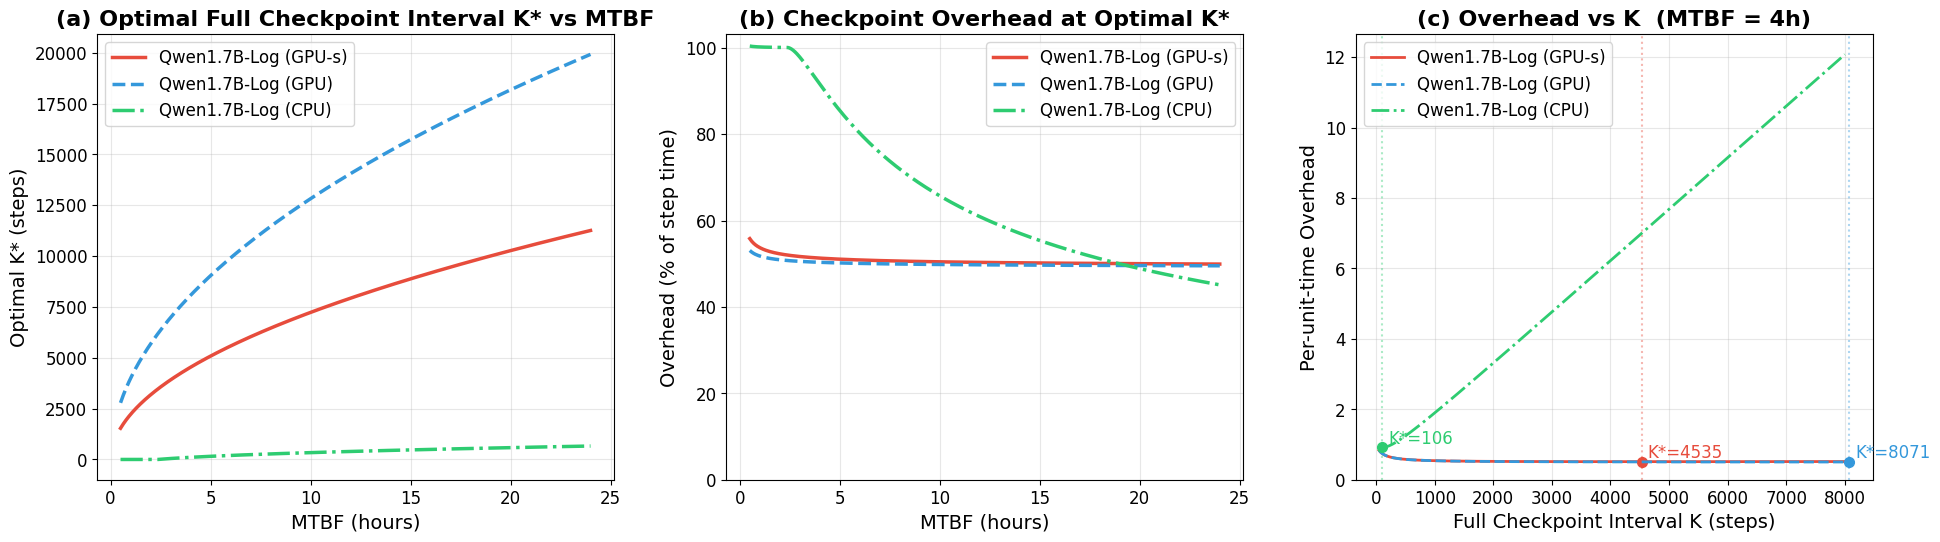

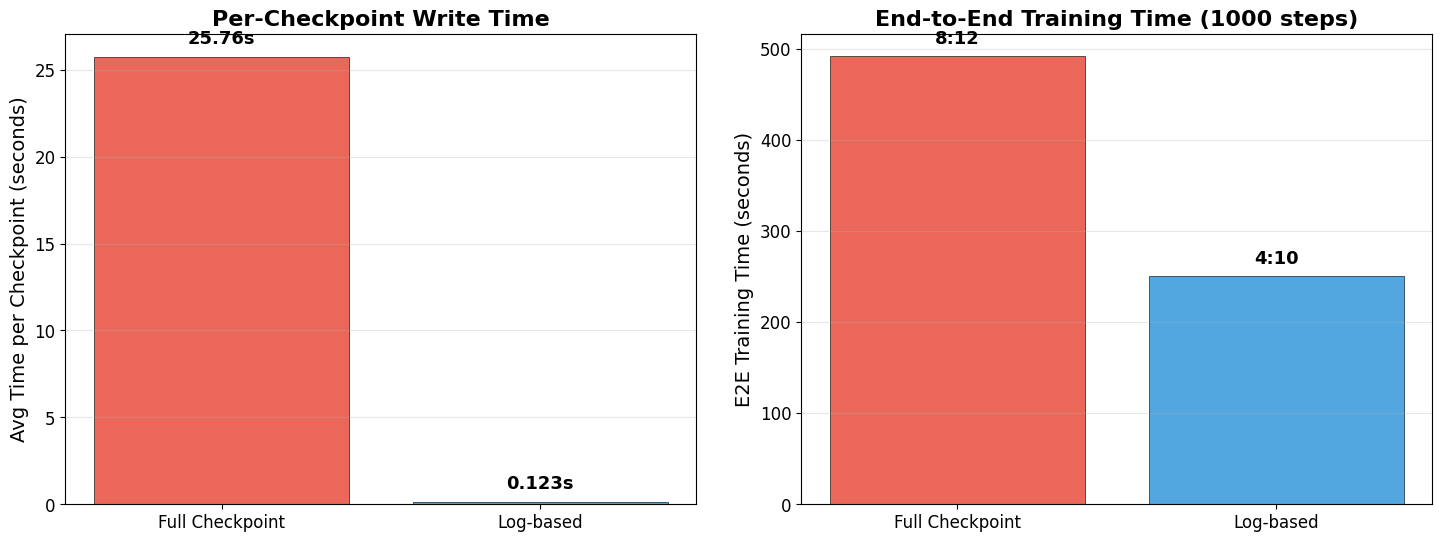

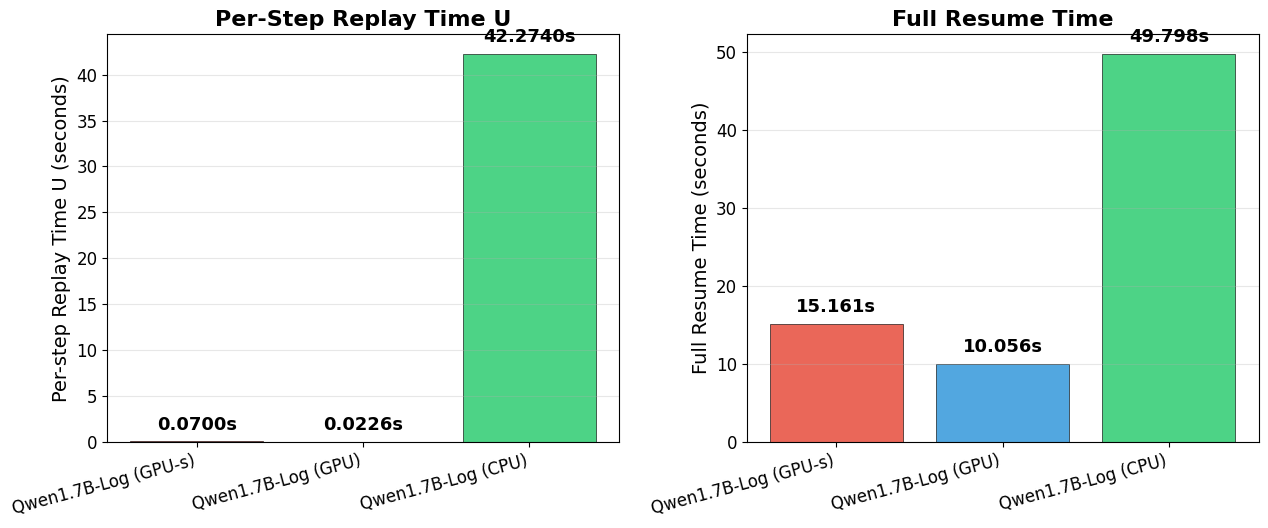

In [10]:
"""
ZO Checkpoint 成本模型 — 数据配置
==================================
只需要填测量数据，其他全部自动计算
"""

import sys
import importlib
sys.path.insert(0, '/home/users/u0001609/NonStopZO2/experiments')

import zo_optimal_K_model
importlib.reload(zo_optimal_K_model)
from zo_optimal_K_model import (
    print_summary,
    plot_cost_model,
    plot_strategy_comparison,
    plot_replay_speed,
    compute_replay_params,
)
import matplotlib.pyplot as plt

# ╔══════════════════════════════════════════════════════════════╗
# ║                    在这里填测量数据                            ║
# ╚══════════════════════════════════════════════════════════════╝

# ========== 基本参数 ==========
TOTAL_STEPS = 1000          # 总训练步数
C           = 25.758        # Full checkpoint 写入时间 (秒)
STEP_TIME   = 0.128          # 每步训练时间 (秒)

# ========== 统一实验组（每组一个字典，包含 checkpoint + replay 数据）==========
# avg_ckpt_time    → 自动用作 tl（不需要手动填 tl）
# replay_data      → 至少 2 个点，每个点包含 {replay_steps, replay_time, full_resume_time}
#                    用斜率拟合 U；cold_start_i = full_resume_time_i - U * steps_i，取平均
# ckpt_label       → strategy comparison 去重标签（可选，默认用 name）
experiment_groups = [
    {
        "name": "Full Checkpoint",
        "avg_ckpt_time": 25.758,
        "total_ckpts": 10,
        "e2e_time_seconds": 492,
        "replay_data": [
            {"replay_steps": 0, "replay_time": 0},
        ],
    },
    {
        "name": "Qwen1.7B-Log (GPU-s)",
        "ckpt_label": "Log-based",
        "avg_ckpt_time": 0.123,
        "total_ckpts": 1000,
        "e2e_time_seconds": 250.525,
        "replay_data": [
            {"replay_steps": 1,   "replay_time": 0.386,  "full_resume_time": 8.299},
            {"replay_steps": 100, "replay_time": 7.320,  "full_resume_time": 15.161},
        ],
    },
    {
        "name": "Qwen1.7B-Log (GPU)",
        "ckpt_label": "Log-based",
        "avg_ckpt_time": 0.123,
        "total_ckpts": 1000,
        "e2e_time_seconds": 250.525,
        "replay_data": [
            {"replay_steps": 1,   "replay_time": 0.828,  "full_resume_time": 8.786},
            {"replay_steps": 100, "replay_time": 3.061,  "full_resume_time": 10.056},
        ],
    },
    {
        "name": "Qwen1.7B-Log (CPU)",
        "ckpt_label": "Log-based",
        "avg_ckpt_time": 0.0043,
        "total_ckpts": 1000,
        "e2e_time_seconds": 238.72,
        "replay_data": [
            {"replay_steps": 1,  "replay_time": 42.274,  "full_resume_time": 49.798},
        ],
    },
]

# ========== MTBF 配置 ==========
MTBF_RANGE_HOURS  = (0.5, 24)
MTBF_DEMO_HOURS   = 4
MTBF_TABLE_VALUES = [1, 2, 4, 8, 12, 24]

# ╔══════════════════════════════════════════════════════════════╗
# ║              自动计算（不需要手动填）                           ║
# ╚══════════════════════════════════════════════════════════════╝

# 按 name 分组，拟合 U，cold_start = mean(full_resume_i - U * steps_i)
replay_params = compute_replay_params(experiment_groups)
print("=== 自动计算的回放参数 ===")
for name, p in replay_params.items():
    frt = p.get('full_resume_time')
    frt_str = f"{frt:.3f}s" if frt is not None else "N/A"
    print(f"  {name}: U={p['U']:.4f}s/step, full_resume={frt_str}, cold_start={p['cold_start']:.3f}s, tl={p['tl']:.4f}s")

replay_scenarios = list(replay_params.values())

# ╔══════════════════════════════════════════════════════════════╗
# ║                       输出和画图                              ║
# ╚══════════════════════════════════════════════════════════════╝

# 1) 打印计算结果
print_summary(C, STEP_TIME, replay_scenarios,
              experiment_groups, TOTAL_STEPS, MTBF_TABLE_VALUES)

# 2) 图1：成本模型（每组用自己的 tl）
fig1 = plot_cost_model(C, STEP_TIME, replay_scenarios,
                       MTBF_RANGE_HOURS, MTBF_DEMO_HOURS)

# 3) 图2：各 checkpoint 策略对比（自动按 ckpt_label 去重）
fig2 = plot_strategy_comparison(experiment_groups, TOTAL_STEPS)

# 4) 图3：每步回放时间 + 完整恢复时间（按 name 分组）
fig3 = plot_replay_speed(experiment_groups)

plt.show()